In [17]:
import argparse
import json
import math
import os
import random
from time import time
import mlflow
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from collections import defaultdict

# import pytrec_eval
import torch
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.utils.data import DataLoader, RandomSampler
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, AutoTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from accelerate import Accelerator
from copy import deepcopy

torch.backends.cuda.matmul.allow_tf32 = True

from watchog.dataset import (
    # collate_fn,
    TURLColTypeTablewiseDataset,
    TURLRelExtTablewiseDataset,
    SatoCVTablewiseDataset,
    ColPoplTablewiseDataset
)

from watchog.dataset import TableDataset, SupCLTableDataset, SemtableCVTablewiseDataset, GittablesColwiseDataset, GittablesCVTablewiseDataset
from watchog.model import BertMultiPairPooler, BertForMultiOutputClassification, BertForMultiOutputClassificationColPopl
from watchog.model import SupCLforTable, UnsupCLforTable, lm_mp
from watchog.utils import load_checkpoint, f1_score_multilabel, collate_fn, get_col_pred, ColPoplEvaluator
from watchog.utils import task_num_class_dict
from accelerate import DistributedDataParallelKwargs
import wandb

[nltk_data] Downloading package punkt to /home/zhihao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zhihao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    parser = argparse.ArgumentParser()
    parser.add_argument("--wandb", type=bool, default=False)
    parser.add_argument("--model", type=str, default="Watchog")
    parser.add_argument("--unlabeled_train_only", type=bool, default=False)
    parser.add_argument("--context_encoding_type", type=str, default="v0")
    parser.add_argument("--pool_version", type=str, default="v0.2")
    parser.add_argument("--random_sample", type=bool, default=False)
    parser.add_argument("--comment", type=str, default="debug", help="to distinguish the runs")
    parser.add_argument(
        "--shortcut_name",
        default="bert-base-uncased",
        type=str,
        help="Huggingface model shortcut name ",
    )
    parser.add_argument(
        "--max_length",
        default=64,
        type=int,
        help=
        "The maximum total input sequence length after tokenization. Sequences longer "
        "than this will be truncated, sequences shorter will be padded.",
    )
    parser.add_argument(
        "--adaptive_max_length",
        default=False,
        type=bool,
    )    
    parser.add_argument(
        "--max_num_col",
        default=8,
        type=int,
    )   

    parser.add_argument(
        "--batch_size",
        default=16,
        type=int,
        help="Batch size",
    )
    parser.add_argument(
        "--epoch",
        default=1,
        type=int,
        help="Number of epochs for training",
    )
    parser.add_argument(
        "--random_seed",
        default=4649,
        type=int,
        help="Random seed",
    )
    
    parser.add_argument(
        "--train_n_seed_cols",
        default=-1,
        type=int,
        help="number of seeding columns in training",
    )

    parser.add_argument(
        "--num_classes",
        default=78,
        type=int,
        help="Number of classes",
    )
    parser.add_argument("--multi_gpu",
                        action="store_true",
                        default=False,
                        help="Use multiple GPU")
    parser.add_argument("--fp16",
                        action="store_true",
                        default=False,
                        help="Use FP16")
    parser.add_argument("--warmup",
                        type=float,
                        default=0.,
                        help="Warmup ratio")
    parser.add_argument("--lr", type=float, default=5e-5, help="Learning rate")
    parser.add_argument("--task",
                        type=str,
                        default='gt-semtab22-dbpedia-all0',
                        choices=[
                            "sato0", "sato1", "sato2", "sato3", "sato4",
                            "msato0", "msato1", "msato2", "msato3", "msato4",
                            "gt-dbpedia0", "gt-dbpedia1", "gt-dbpedia2", "gt-dbpedia3", "gt-dbpedia4",
                            "gt-dbpedia-all0", "gt-dbpedia-all1", "gt-dbpedia-all2", "gt-dbpedia-all3", "gt-dbpedia-all4",
                            "gt-schema-all0", "gt-schema-all1", "gt-schema-all2", "gt-schema-all3", "gt-schema-all4",
                            "gt-semtab22-dbpedia", "gt-semtab22-dbpedia0", "gt-semtab22-dbpedia1", "gt-semtab22-dbpedia2", "gt-semtab22-dbpedia3", "gt-semtab22-dbpedia4",
                            "gt-semtab22-dbpedia-all", "gt-semtab22-dbpedia-all0", "gt-semtab22-dbpedia-all1", "gt-semtab22-dbpedia-all2", "gt-semtab22-dbpedia-all3", "gt-semtab22-dbpedia-all4",
                            "gt-semtab22-schema-class-all", "gt-semtab22-schema-property-all",
                            "turl", "turl-re", "col-popl-1", "col-popl-2", "col-popl-3", "row-popl",
                            "col-popl-turl-0", "col-popl-turl-1", "col-popl-turl-2",
                            "col-popl-turl-mdonly-0", "col-popl-turl-mdonly-1", "col-popl-turl-mdonly-2"
                        ],
                        help="Task names}")
    parser.add_argument("--colpair",
                        action="store_true",
                        help="Use column pair embedding")
    parser.add_argument("--metadata",
                        action="store_true",
                        help="Use column header metadata")
    parser.add_argument("--from_scratch",
                        action="store_true",
                        help="Training from scratch")
    parser.add_argument("--cl_tag",
                        type=str,
                        default="wikitables/simclr/bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt",
                        help="path to the pre-trained file")
    parser.add_argument("--dropout_prob",
                        type=float,
                        default=0.5)
    parser.add_argument("--eval_test",
                        action="store_true",
                        help="evaluate on testset and do not save the model file")
    parser.add_argument("--small_tag",
                        type=str,
                        default="semi1",
                        help="e.g., by_table_t5_v1")
    parser.add_argument("--data_path",
                        type=str,
                        default="/data/zhihao/TU/")
    parser.add_argument("--pretrained_ckpt_path",
                        type=str,
                        default="/data/zhihao/TU/Watchog/model/")    

    args = parser.parse_args([])
    task = "sato0"
    
    args.num_classes = task_num_class_dict[task]
    if args.colpair:
        assert "turl-re" == task, "colpair can be only used for Relation Extraction"
    if args.metadata:
        assert "turl-re" == task or "turl" == task, "metadata can be only used for TURL datasets"
    if "col-popl":
        # metrics = {
        #     "accuracy": CategoricalAccuracy(tie_break=True),
        # }
        if args.train_n_seed_cols != -1:
            if "col-popl" in task:
                assert args.train_n_seed_cols == int(task[-1]),  "# of seed columns must match"

    print("args={}".format(json.dumps(vars(args))))

    max_length = args.max_length
    batch_size = args.batch_size
    num_train_epochs = args.epoch

    shortcut_name = args.shortcut_name

    if args.colpair and args.metadata:
        taskname = "{}-colpair-metadata".format(task)
    elif args.colpair:
        taskname = "{}-colpair".format(task)
    elif args.metadata:
        taskname = "{}-metadata".format(task)
    elif args.train_n_seed_cols == -1 and 'popl' in task:
        taskname = "{}-mix".format(task)
    else:
        taskname = "".join(task)
    cv = int(task[-1])

    if args.from_scratch:
        if "gt" in task:
            tag_name = "{}/{}-{}-{}-pool{}-max_cols{}-rand{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname,  "{}-fromscratch".format(shortcut_name), args.small_tag, args.comment, args.pool_version, args.max_num_col, args.random_sample,
                batch_size, max_length, num_train_epochs, args.dropout_prob, 
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        else:
            tag_name = "{}/{}-{}-{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname,  "{}-fromscratch".format(shortcut_name), args.small_tag, args.comment, 
                batch_size, max_length, num_train_epochs, args.dropout_prob, 
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        
    else:
        if "gt" in task:
            tag_name = "{}/{}_{}-pool{}-max_cols{}-rand{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname, args.cl_tag.replace('/', '-'),  shortcut_name, args.small_tag, args.pool_version, args.max_num_col, args.random_sample,
                batch_size, max_length, num_train_epochs, args.dropout_prob,
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')
        else:
            tag_name = "{}/{}_{}-{}-bs{}-ml{}-ne{}-do{}{}".format(
                taskname, args.cl_tag.replace('/', '-'),  shortcut_name, args.small_tag,
                batch_size, max_length, num_train_epochs, args.dropout_prob,
                '-rs{}'.format(args.random_seed) if args.random_seed != 4649 else '')

    # if args.eval_test:
    #     if args.small_tag != '':
    #         tag_name = tag_name.replace('outputs', 'small_outputs')
    #         tag_name += '-' + args.small_tag
    print(tag_name)
    file_path = os.path.join(args.data_path, "Watchog", "outputs", tag_name)

    dirpath = os.path.dirname(file_path)
    if not os.path.exists(dirpath):
        print("{} not exists. Created".format(dirpath))
        os.makedirs(dirpath)
    
    if args.fp16:
        torch.backends.cuda.matmul.allow_fp16_reduced_precision_reduction = True
        
      
        
    # accelerator = Accelerator(mixed_precision="no" if not args.fp16 else "fp16")   
    ddp_kwargs = DistributedDataParallelKwargs(find_unused_parameters=True)
    accelerator = Accelerator(mixed_precision="no" if not args.fp16 else "fp16", kwargs_handlers=[ddp_kwargs])

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    ckpt_path = os.path.join(args.pretrained_ckpt_path, args.cl_tag)
    # ckpt_path = '/efs/checkpoints/{}.pt'.format(args.cl_tag)
    ckpt = torch.load(ckpt_path, map_location=device)
    ckpt_hp = ckpt['hp']
    print(ckpt_hp)
 
    setattr(ckpt_hp, 'batch_size', args.batch_size)
    setattr(ckpt_hp, 'hidden_dropout_prob', args.dropout_prob)
    setattr(ckpt_hp, 'shortcut_name', args.shortcut_name)
    setattr(ckpt_hp, 'num_labels', args.num_classes)
    
    
    
    tokenizer = BertTokenizer.from_pretrained(shortcut_name)
    padder = collate_fn(tokenizer.pad_token_id)
    if task == "turl-re" and args.colpair:
        model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, col_pair='Pair')
    elif "col-popl" in task:
        model = BertForMultiOutputClassificationColPopl(ckpt_hp, device=device, lm=ckpt['hp'].lm, n_seed_cols=int(task[i][-1]), cls_for_md="md" in task)
    else:
        model = BertForMultiOutputClassification(ckpt_hp, device=device, lm=ckpt['hp'].lm, version="v0")
        


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


args={"wandb": false, "model": "Watchog", "unlabeled_train_only": false, "context_encoding_type": "v0", "pool_version": "v0.2", "random_sample": false, "comment": "debug", "shortcut_name": "bert-base-uncased", "max_length": 64, "adaptive_max_length": false, "max_num_col": 8, "batch_size": 16, "epoch": 1, "random_seed": 4649, "train_n_seed_cols": -1, "num_classes": 78, "multi_gpu": false, "fp16": false, "warmup": 0.0, "lr": 5e-05, "task": "gt-semtab22-dbpedia-all0", "colpair": false, "metadata": false, "from_scratch": false, "cl_tag": "wikitables/simclr/bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt", "dropout_prob": 0.5, "eval_test": false, "small_tag": "semi1", "data_path": "/data/zhihao/TU/", "pretrained_ckpt_path": "/data/zhihao/TU/Watchog/model/"}
sato0/wikitables-simclr-bert_100000_10_32_256_5e-05_sample_row4,sample_row4_tfidf_entity_column_0.05_0_last.pt_bert-base-uncased-semi1-bs16-ml64-ne1-do0.5


/tmp/ipykernel_3362360/3400499614.py:212: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)


Namespace(augment_op='sample_row4,sample_row4', batch_size=32, data_path='/data/zhihao/TU/TURL/', fp16=True, gpus='0', lm='bert', logdir='/data/zhihao/TU/Watchog/model/', lr=5e-05, max_len=256, mode='simclr', model='Watchog', n_epochs=10, pretrain_data='wikitables', pretrained_model_path='', projector=768, run_id=0, sample_meth='tfidf_entity', save_model=10, single_column=False, size=100000, table_order='column', temperature=0.05)


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [24]:

base_dirpath = os.path.join(args.data_path, "doduo", "data")
seperator = "semi1"
basename = "sato_cv_{}.csv"
df_list = []
filepath = os.path.join(base_dirpath, basename.format(cv))
df_test = pd.read_csv(filepath)

df_group_test = df_test.groupby("table_id")



df_list = []
for i in range(5):
    if i == cv:
        continue
    filepath = os.path.join(base_dirpath, basename.format(i))
    df_list.append(pd.read_csv(filepath))
df_train = pd.concat(df_list, axis=0)
df_group_train = df_train.groupby("table_id")

In [25]:
from sentence_transformers import SentenceTransformer

st_model = SentenceTransformer("all-mpnet-base-v2", cache_folder="/data/zhihao/TU/Watchog/sentence_transformers_cache")

In [46]:
labels_cluster = []
embeddings_cluster = []
embeddings_cluster_context = []
for i, (index, group_df) in enumerate(df_group_train):
    if len(group_df) < 2:
        continue
    labeled_columns = group_df[group_df['class_id'] > -1]
    labels_cluster += labeled_columns["class_id"].values.tolist()
    # if len(labeled_columns) > 1:
    #     embeddings_cluster.append(ft_model.get_sentence_vector(" ".join(labeled_columns["data"].values)))
    #     embeddings_cluster_context.append(ft_model.get_sentence_vector(" ".join(group_df["data"].values)))
    #     break
    for text in labeled_columns["data"].values:
        embeddings_cluster.append(st_model.encode(text))
        embeddings_cluster_context.append(st_model.encode(st_model.tokenizer.sep_token.join(group_df["data"].values)))

In [47]:
embeddings_cluster = np.stack(embeddings_cluster, axis=0)
embeddings_cluster_context = np.stack(embeddings_cluster_context, axis=0)
labels_cluster = np.array(labels_cluster)

In [48]:
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
def silhouette_score_per_cluster(embeddings, labels, metric="cosine"):
    sample_silhouette_values = silhouette_samples(embeddings, labels, metric=metric)
    unique_labels = np.unique(labels)
    silhouette_per_cluster = []
    for label in unique_labels:
        cluster_silhouettes = sample_silhouette_values[labels == label]
        silhouette_per_cluster.append(np.mean(cluster_silhouettes))
    return np.array(silhouette_per_cluster).reshape(-1)
embeddings_cluster_silhouette_values = silhouette_samples(embeddings_cluster, labels_cluster)
embeddings_cluster_context_silhouette_values = silhouette_samples(embeddings_cluster_context, labels_cluster)

In [51]:
np.mean(embeddings_cluster_silhouette_values)

0.012887055

In [52]:
np.mean(embeddings_cluster_context_silhouette_values)

-0.060685627

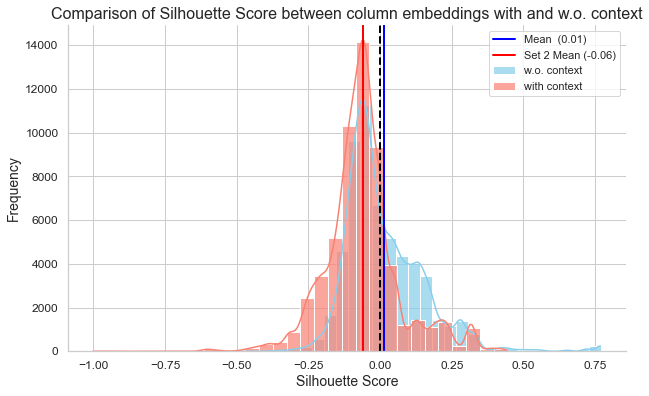

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example data: Two sets of values
values_set_1 = embeddings_cluster_silhouette_values  # Replace with your actual data
values_set_2 = embeddings_cluster_context_silhouette_values  # Replace with your second set of values

mean_set_1 = np.mean(values_set_1)
mean_set_2 = np.mean(values_set_2)
# Set the style of the visualization
sns.set(style="whitegrid")

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot the first set of values
sns.histplot(values_set_1, color='skyblue', kde=True, label='w.o. context', bins=30, alpha=0.7)

# Plot the second set of values
sns.histplot(values_set_2, color='salmon', kde=True, label='with context', bins=30, alpha=0.7)

# Add a vertical line at x=0 for reference
plt.axvline(x=0, color='black', linestyle='--', linewidth=2)

plt.axvline(x=mean_set_1, color='blue', linestyle='-', linewidth=2, label=f'Mean  ({mean_set_1:.2f})')
plt.axvline(x=mean_set_2, color='red', linestyle='-', linewidth=2, label=f'Set 2 Mean ({mean_set_2:.2f})')

# Customize the plot
plt.title('Comparison of Silhouette Score between column embeddings with and w.o. context', fontsize=16)
plt.xlabel('Silhouette Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Remove the top and right spines for a cleaner look
sns.despine()

# Show the plot
plt.show()

In [4]:
text = "BERT is a powerful language model."
tokenizer.tokenize(text)

['bert', 'is', 'a', 'powerful', 'language', 'model', '.']

In [21]:
os.path.join(args.data_path, "doduo", "data")

'/data/zhihao/TU/doduo/data'

In [3]:
max_length = 64
cv = 0
dataset_cls = SatoCVTablewiseDataset
train_dataset = dataset_cls(cv=cv,
                            split="train",
                            tokenizer=tokenizer,
                            max_length=max_length,
                            multicol_only=False,
                            train_ratio=1.0,
                            device=device,
                            small_tag="",
                            base_dirpath=os.path.join(args.data_path, "doduo", "data"), 
                            )
valid_dataset = dataset_cls(cv=cv,
                            split="valid",
                            tokenizer=tokenizer,
                            max_length=max_length,
                            multicol_only=False,
                            train_ratio=1.0,
                            device=device,
                            small_tag="",
                            base_dirpath=os.path.join(args.data_path, "doduo", "data"))

KeyboardInterrupt: 

In [4]:
test_dataset = dataset_cls(cv=cv,
                            split="test",
                            tokenizer=tokenizer,
                            max_length=max_length,
                            multicol_only=False,
                            train_ratio=1.0,
                            device=device,
                            small_tag="",
                            base_dirpath=os.path.join(args.data_path, "doduo", "data"))

test 15736


In [6]:
train_dataloader = DataLoader(train_dataset,
                                batch_size=batch_size,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)
valid_dataloader = DataLoader(valid_dataset,
                                batch_size=batch_size,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)
test_dataloader = DataLoader(test_dataset,
                                batch_size=batch_size,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [35]:
def extract_cls_tokens(hidden_states, cls_indexes, head=False):
    cls_embeddings = []
    for i, j in cls_indexes:
        sub_sentence_cls_embeddings = hidden_states[i, 0, :] if head else hidden_states[i, j, :]
        cls_embeddings.append(sub_sentence_cls_embeddings)
    cls_embeddings = torch.stack(cls_embeddings)
    return cls_embeddings
#pooled_outputs = extract_cls_tokens(hidden_states, cls_indexes)

In [8]:
model.eval()
model = model.to(device)
plm_embs_train = []
labels_train = []
for batch_idx, batch in enumerate(test_dataloader):
    cls_indexes = torch.nonzero(
                    batch["data"].T == tokenizer.cls_token_id)
    break

In [12]:
batch_data = torch.cat([batch["data"].T, torch.ones([16, 512]).long().to(device)], dim=1)

In [33]:
model.eval()
model = model.to(device)
plm_embs_train = []
labels_train = []
for batch_idx, batch in enumerate(train_dataloader):
    cls_indexes = torch.nonzero(
                    batch["data"].T == tokenizer.cls_token_id)
    embs = model.bert(batch["data"].T)
    embs = extract_cls_tokens(embs[0], cls_indexes)
    plm_embs_train.append(embs.detach().cpu())
    labels_train.append(batch["label"].cpu())
plm_embs_train = torch.cat(plm_embs_train, dim=0)
labels_train = torch.cat(labels_train, dim=0)

In [7]:
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
def silhouette_score_per_cluster(embeddings, labels, metric="cosine"):
    sample_silhouette_values = silhouette_samples(embeddings, labels, metric=metric)
    unique_labels = np.unique(labels)
    silhouette_per_cluster = []
    for label in unique_labels:
        cluster_silhouettes = sample_silhouette_values[labels == label]
        silhouette_per_cluster.append(np.mean(cluster_silhouettes))
    return np.array(silhouette_per_cluster).reshape(-1)

In [9]:
plm_embs_train_silhouette_values = silhouette_samples(plm_embs_train, labels_train)

In [10]:
plm_embs_train_silhouette_values.shape

(76293,)

In [11]:
np.mean(plm_embs_train_silhouette_values)

-0.2796932

<Axes: ylabel='Count'>

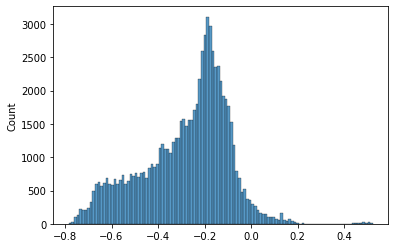

In [12]:
import seaborn as sns
sns.histplot(plm_embs_train_silhouette_values)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming plm_embs_train_silhouette_values is your data
sns.histplot(plm_embs_train_silhouette_values)

# Add a red vertical line at x = 0
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)

# Display the plot
plt.show()


In [15]:
unique_labels = np.unique(labels_train)
silhouette_per_cluster = []
for label in unique_labels:
    cluster_silhouettes = plm_embs_train_silhouette_values[labels_train == label]
    silhouette_per_cluster.append(np.mean(cluster_silhouettes))
plm_embs_train_silhouette_per_cluster = np.array(silhouette_per_cluster).reshape(-1)

In [19]:
len(plm_embs_train_silhouette_per_cluster)

78

78

In [36]:
import json
import numpy as np

# Function to load confusion matrix from JSON file
# with open("/data/zhihao/TU/doduo/eval/sato0_mosato_bert_bert-base-uncased-bs16-ml-32__sato0-1.00=sato0.json", 'r') as f:
#     results = json.load(f)
with open(f"/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fromscratch-bs16-ml64-ne30-do0.1_eval.json", 'r') as f:
    results = json.load(f)

# labels_train = np.array(results['train']['tr_true_list'])
# preds_train = np.array(results['train']['tr_pred_list'])
# class_f1_train = np.array(results['train']['tr_class_f1'])

labels = np.array(results['f1_micro']['true_list'])
preds = np.array(results['f1_micro']['pred_list'])
class_f1 = np.array(results['f1_micro']['ts_class_f1'])

In [21]:
from scipy.stats import pearsonr
pearsonr(plm_embs_train_silhouette_per_cluster, class_f1)

PearsonRResult(statistic=0.23853156990576638, pvalue=0.035456857437006634)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


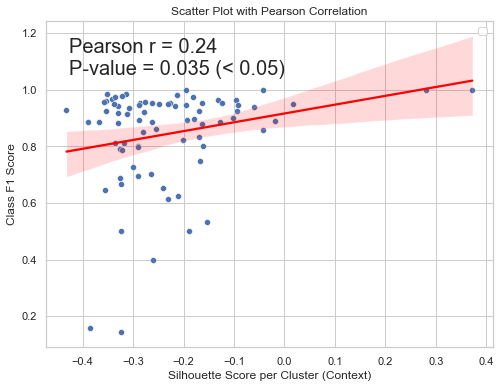

In [22]:
# Set the style of seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
corr, p_value = pearsonr(plm_embs_train_silhouette_per_cluster , class_f1)
# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=plm_embs_train_silhouette_per_cluster, y=class_f1)

# Add a line of best fit
sns.regplot(x=plm_embs_train_silhouette_per_cluster, y=class_f1, scatter=False, color='red', line_kws={"label":f"Pearson r={corr:.2f}"})

# Add labels and title
plt.xlabel("Silhouette Score per Cluster (Context)")
plt.ylabel("Class F1 Score")
plt.title("Scatter Plot with Pearson Correlation")

plt.text(0.05, 0.95, f'Pearson r = {corr:.2f}\nP-value = {p_value:.3f} (< 0.05)',
         transform=plt.gca().transAxes,
         fontsize=20,
         verticalalignment='top')
# Display the legend with Pearson correlation
plt.legend()

# Show the plot
plt.show()

In [19]:
best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fromscratch-bs16-ml64-ne30-do0.1_best_f1_micro.pt", map_location=device)
model.load_state_dict(best_state_dict, strict=False)

/tmp/ipykernel_662838/1121875279.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fr

_IncompatibleKeys(missing_keys=['pooler.dense_tab.weight', 'pooler.dense_tab.bias'], unexpected_keys=[])

In [35]:
model.eval()
model = model.to(device)
ft_embs_train = []
labels_train = []
for batch_idx, batch in enumerate(train_dataloader):
    cls_indexes = torch.nonzero(
                    batch["data"].T == tokenizer.cls_token_id)
    embs = model.bert(batch["data"].T)
    embs = extract_cls_tokens(embs[0], cls_indexes)
    ft_embs_train.append(embs.detach().cpu())
    labels_train.append(batch["label"].cpu())
ft_embs_train = torch.cat(ft_embs_train, dim=0)
labels_train = torch.cat(labels_train, dim=0)

In [36]:
ft_embs_train_silhouette_values = silhouette_samples(ft_embs_train, labels_train)

In [37]:
np.mean(ft_embs_train_silhouette_values)

0.73636717

In [41]:
unique_labels = np.unique(labels_train)
silhouette_per_cluster = []
for label in unique_labels:
    cluster_silhouettes = ft_embs_train_silhouette_values[labels_train == label]
    silhouette_per_cluster.append(np.mean(cluster_silhouettes))
ft_embs_train_silhouette_per_cluster = np.array(silhouette_per_cluster).reshape(-1)

In [42]:
from scipy.stats import pearsonr
pearsonr(ft_embs_train_silhouette_per_cluster, class_f1)

PearsonRResult(statistic=0.6810263798796665, pvalue=6.842797273634585e-12)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


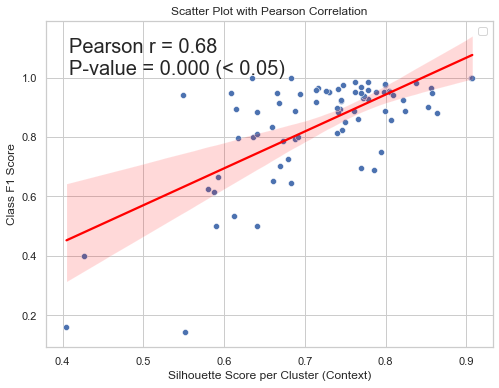

In [43]:
# Set the style of seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
corr, p_value = pearsonr(ft_embs_train_silhouette_per_cluster, class_f1)
# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=ft_embs_train_silhouette_per_cluster, y=class_f1)

# Add a line of best fit
sns.regplot(x=ft_embs_train_silhouette_per_cluster, y=class_f1, scatter=False, color='red', line_kws={"label":f"Pearson r={corr:.2f}"})

# Add labels and title
plt.xlabel("Silhouette Score per Cluster (Context)")
plt.ylabel("Class F1 Score")
plt.title("Scatter Plot with Pearson Correlation")

plt.text(0.05, 0.95, f'Pearson r = {corr:.2f}\nP-value = {p_value:.3f} (< 0.05)',
         transform=plt.gca().transAxes,
         fontsize=20,
         verticalalignment='top')
# Display the legend with Pearson correlation
plt.legend()

# Show the plot
plt.show()

In [38]:
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
for batch_idx, batch in enumerate(test_dataloader):
    cls_indexes = torch.nonzero(
                    batch["data"].T == tokenizer.cls_token_id)
    embs = model.bert(batch["data"].T)
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    embs = extract_cls_tokens(embs[0], cls_indexes)
    ft_embs_test.append(embs.detach().cpu())
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
ft_embs_test = torch.cat(ft_embs_test, dim=0)
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.cat(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [74]:
logits_test.shape

torch.Size([23820, 78])

In [40]:
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()

In [41]:
len(ts_pred_list)

23820

In [42]:
from sklearn.metrics import confusion_matrix, f1_score
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.9438, ts_macro_f1=0.8449


In [45]:
labels.shape

(23820,)

In [49]:
torch.equal(torch.tensor(labels), labels_test)

True

In [50]:
ft_embs_test_silhouette_values = silhouette_samples(torch.cat([ft_embs_test, ft_embs_train]), torch.cat([labels_test, labels_train]))[: len(labels_test)]

In [51]:
np.mean(ft_embs_test_silhouette_values)

0.64787555

In [53]:
unique_labels = np.unique(labels_train)
silhouette_per_cluster = []
for label in unique_labels:
    cluster_silhouettes = ft_embs_test_silhouette_values[labels_test == label]
    silhouette_per_cluster.append(np.mean(cluster_silhouettes))
ft_embs_test_silhouette_per_cluster = np.array(silhouette_per_cluster).reshape(-1)

In [54]:
from scipy.stats import pearsonr
pearsonr(ft_embs_test_silhouette_per_cluster, class_f1)

PearsonRResult(statistic=0.9087757099193224, pvalue=1.4235298079845303e-30)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


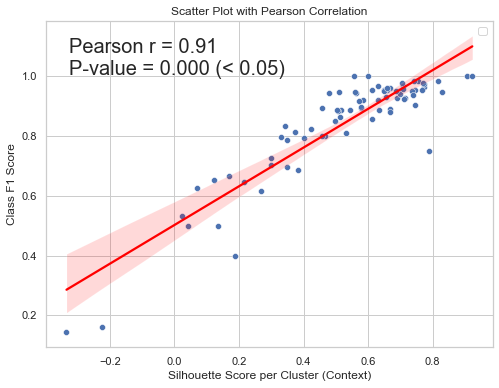

In [55]:
# Set the style of seaborn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
corr, p_value = pearsonr(ft_embs_test_silhouette_per_cluster, class_f1)
# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=ft_embs_test_silhouette_per_cluster, y=class_f1)

# Add a line of best fit
sns.regplot(x=ft_embs_test_silhouette_per_cluster, y=class_f1, scatter=False, color='red', line_kws={"label":f"Pearson r={corr:.2f}"})

# Add labels and title
plt.xlabel("Silhouette Score per Cluster (Context)")
plt.ylabel("Class F1 Score")
plt.title("Scatter Plot with Pearson Correlation")

plt.text(0.05, 0.95, f'Pearson r = {corr:.2f}\nP-value = {p_value:.3f} (< 0.05)',
         transform=plt.gca().transAxes,
         fontsize=20,
         verticalalignment='top')
# Display the legend with Pearson correlation
plt.legend()

# Show the plot
plt.show()

<Axes: ylabel='Count'>

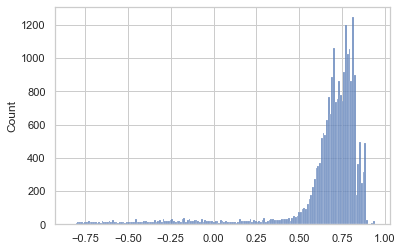

In [56]:
sns.histplot(ft_embs_test_silhouette_values)

In [60]:
(preds == labels).sum()/len(labels)

0.9437867338371116

In [61]:
(ft_embs_test_silhouette_values<0).sum()/len(ft_embs_test_silhouette_values)

0.05860621326616289

In [63]:
((preds != labels) & (ft_embs_test_silhouette_values<0)).sum()/(preds != labels).sum()

0.9716206123973115

In [66]:
results['f1_micro'].keys()

dict_keys(['ts_micro_f1', 'ts_macro_f1', 'ts_class_f1', 'ts_conf_mat', 'true_list', 'pred_list'])

In [ ]:
ft_embs_test_silhouette_values

In [82]:
logits_test.max(1)

torch.return_types.max(
values=tensor([13.3896, 15.4858, 15.0345,  ..., 10.3825, 10.3825, 15.4302]),
indices=tensor([22, 46, 46,  ..., 60, 60, 46]))

In [43]:
import torch.nn.functional as F
logits_test = F.softmax(logits_test, dim=1)

In [44]:
ood_score = logits_test.max(1).values
ood_labels = torch.tensor(preds_test == labels).float()

/tmp/ipykernel_4031802/3964349418.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ood_labels = torch.tensor(preds_test == labels).float()


In [45]:
from sklearn.metrics import roc_auc_score

roc_auc_score(ood_labels, ood_score)

0.8936139883321601

In [93]:
ood_score.sort()

torch.return_types.sort(
values=tensor([0.1415, 0.2014, 0.2104,  ..., 1.0000, 1.0000, 1.0000]),
indices=tensor([17080,  2397, 19343,  ..., 11118,  8912, 15166]))

In [95]:
ood_labels[ood_score.sort()[1]][:100]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0.])

In [100]:
0 in ood_labels[ood_score > 0.99]

True

<Axes: ylabel='Count'>

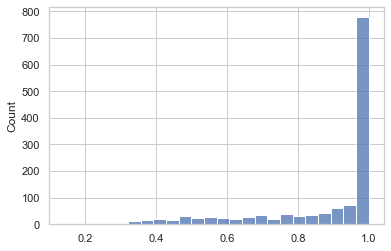

In [103]:
sns.histplot(ood_score[ood_labels==0])

<Axes: ylabel='Count'>

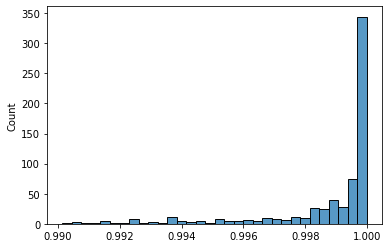

In [11]:
sns.histplot(ood_score[ood_labels==0][ood_score[ood_labels==0]>0.99])

<Axes: ylabel='Count'>

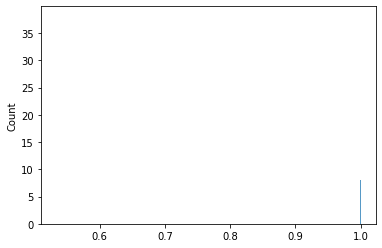

In [13]:
import seaborn as sns
# Generate random permutation of indices
indices = torch.randperm(ood_score[ood_labels==1].shape[0])

# Select the first 2000 indices
selected_indices = indices[:100]
sns.histplot(ood_score[ood_labels==1][selected_indices])

In [14]:
ood_score[ood_labels==1][selected_indices]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9998, 0.9999, 1.0000,
        1.0000, 1.0000, 0.9998, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000,
        0.9999, 1.0000, 0.9998, 1.0000, 0.9999, 0.9999, 1.0000, 1.0000, 0.9999,
        0.9999, 1.0000, 0.9504, 1.0000, 0.9988, 0.5331, 1.0000, 0.9998, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 0.9019, 1.0000,
        1.0000, 1.0000, 0.9998, 1.0000, 0.9999, 1.0000, 0.9999, 0.9998, 0.9999,
        1.0000, 1.0000, 1.0000, 0.9993, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9998, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9998, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9948, 1.0000, 1.0000, 1.0000, 1.0000, 0.9997, 0.9995, 1.0000,
        1.0000])

In [7]:
(ood_score[ood_labels==0] < 0.99).sum()/len(ood_score[ood_labels==0])

tensor(0.5034)

In [8]:
(ood_score[ood_labels==1] < 0.99).sum()/len(ood_score[ood_labels==1])

tensor(0.0250)

In [18]:
(ood_score[ood_labels==0] < 0.9999).sum()/len(ood_score[ood_labels==0])

tensor(0.8275)

In [17]:
(ood_score[ood_labels==1] < 0.9999).sum()/len(ood_score[ood_labels==1])

tensor(0.1950)

In [105]:
len(ood_score[ood_labels==0])

1339

In [108]:
len(ood_score[ood_labels==1][selected_indices])

2000

<Axes: ylabel='Count'>

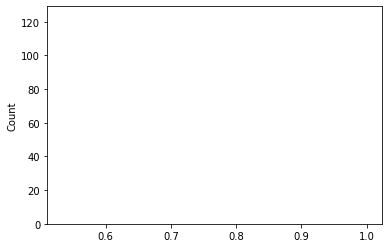

In [4]:
import seaborn as sns
# Generate random permutation of indices
indices = torch.randperm(ood_score[ood_labels==1].shape[0])

# Select the first 2000 indices
selected_indices = indices[:500]
sns.histplot(ood_score[ood_labels==1][selected_indices])

In [1]:
import torch

In [3]:
from argparse import Namespace
import torch
import random
import pandas as pd
import numpy as np
import os
import pickle
import json
import re
import transformers
from torch.utils import data
from torch.nn.utils import rnn
from transformers import AutoTokenizer
from typing import List
from functools import reduce
import operator
from itertools import chain
import copy
class SatoCVTablewiseIterateDataset(data.Dataset):
    """Table dataset for finetuning and evaluating semantic type detection on the SATO dataset"""

    def __init__(
            self,
            cv: int,
            split: str,  # train or test
            tokenizer: AutoTokenizer,
            max_length: int = 256,
            multicol_only: bool = False,
            train_ratio: float = 1.0,
            device: torch.device = None,
            base_dirpath: str = "./data/doduo",
            small_tag: str = "",
            ):
        if device is None:
            device = torch.device('cpu')

        assert split in ["train", "valid",
                         "test"], "split must be train or test"
        if small_tag != '':
            if split in ["train", "valid"]:
                base_dirpath = "./data/doduo_small"
                if split not in small_tag:
                    small_tag += '_' + split
        if multicol_only:
            basename = "msato_cv_{}.csv"
        else:
            basename = "sato_cv_{}.csv"

        if split in ["train", "valid"]:
            if small_tag == "":
                df_list = []
                for i in range(5):
                    if i == cv:
                        continue
                    filepath = os.path.join(base_dirpath, basename.format(i))
                    df_list.append(pd.read_csv(filepath))
                df = pd.concat(df_list, axis=0)
            else:
                filepath = os.path.join(base_dirpath, basename.format(str(cv) + '_' + small_tag))
                df = pd.read_csv(filepath)
        else:
            # test
            filepath = os.path.join(base_dirpath, basename.format(cv))
            df = pd.read_csv(filepath)
        self.df = df
        num_tables = len(df.groupby("table_id"))
        valid_index = int(num_tables * 0.8)
        num_train = int(train_ratio * num_tables * 0.8)
        
        data_list = []
        for i, (index, group_df) in enumerate(df.groupby("table_id")):
            if small_tag == "":
                if (split == "train") and ((i >= num_train) or (i >= valid_index)):
                    break
                if split == "valid" and i < valid_index:
                    continue
            if max_length <= 128:
                cur_maxlen = min(max_length, 512 // len(list(group_df["class_id"].values)) - 1)
            else:
                cur_maxlen = max(1, max_length // len(list(group_df["class_id"].values)) - 1)
            token_ids_list = group_df["data"].apply(lambda x: tokenizer.encode(
                tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
                )
            token_ids = torch.LongTensor(reduce(operator.add,
                                                token_ids_list)).to(device)
            for col_i in range(len(token_ids_list)):
                target_col_mask = []
                cls_index_value = 0
                context_id = 1
                for col_j in range(len(token_ids_list)):
                    if col_j == col_i:
                        target_col_mask += [0] * len(token_ids_list[col_j])
                    else:
                        target_col_mask += [context_id] * len(token_ids_list[col_j])
                        context_id += 1
                    if col_j < col_i:
                        cls_index_value += len(token_ids_list[col_j])
                cls_index_list = [cls_index_value] 
                for cls_index in cls_index_list:
                    assert token_ids[
                        cls_index] == tokenizer.cls_token_id, "cls_indexes validation"
                cls_indexes = torch.LongTensor(cls_index_list).to(device)
                class_ids = torch.LongTensor(
                    [group_df["class_id"].values[col_i]]).to(device)
                target_col_mask = torch.LongTensor(target_col_mask).to(device)
                data_list.append(
                    [index,
                    len(group_df), token_ids, class_ids, cls_indexes, target_col_mask])
        print(split, len(data_list))
        self.table_df = pd.DataFrame(data_list,
                                     columns=[
                                         "table_id", "num_col", "data_tensor",
                                         "label_tensor", "cls_indexes", "target_col_mask"
                                     ])
        """
        # NOTE: msato contains a small portion of single-col tables. keep it to be consistent.  
        if multicol_only:
            # Check
            num_all_tables = len(self.table_df)
            self.table_df = self.table_df[self.table_df["num_col"] > 1]
            assert len(self.table_df) == num_all_tables
        """

    def __len__(self):
        return len(self.table_df)

    def __getitem__(self, idx):
        return {
            "data": self.table_df.iloc[idx]["data_tensor"],
            "label": self.table_df.iloc[idx]["label_tensor"],
            "cls_indexes": self.table_df.iloc[idx]["cls_indexes"],
            "target_col_mask": self.table_df.iloc[idx]["target_col_mask"],
        }
        #"idx": torch.LongTensor([idx])}
        #"cls_indexes": self.table_df.iloc[idx]["cls_indexes"]}

In [4]:
def collate_fn(pad_token_id, data_only=True):
    '''padder for input batch'''

    def padder(samples):    
        data = torch.nn.utils.rnn.pad_sequence(
            [sample["data"] for sample in samples], padding_value=pad_token_id)
        if not data_only:
            label = torch.nn.utils.rnn.pad_sequence(
                [sample["label"] for sample in samples], padding_value=-1)
        else:
            label = torch.cat([sample["label"] for sample in samples])
        batch = {"data": data, "label": label}
        if "idx" in samples[0]:
            batch["idx"] = [sample["idx"] for sample in samples]
        if "cls_indexes" in samples[0]:
            cls_indexes = torch.nn.utils.rnn.pad_sequence(
                [sample["cls_indexes"] for sample in samples], padding_value=0)
            batch["cls_indexes"] = cls_indexes
        if "target_col_mask" in samples[0]:
            target_col_mask = torch.nn.utils.rnn.pad_sequence(
                [sample["target_col_mask"] for sample in samples], padding_value=-1)
            batch["target_col_mask"] = target_col_mask
        if "table_embedding" in samples[0]:
            table_embeddings = [sample["table_embedding"] for sample in samples]
            batch["table_embedding"] = torch.stack(table_embeddings, dim=0)
        return batch
        
    return padder

In [170]:
max_length = 64
cv = 0
train_dataset_iter = SatoCVTablewiseIterateDataset(cv=cv,
                            split="train",
                            tokenizer=tokenizer,
                            max_length=max_length,
                            multicol_only=False,
                            train_ratio=1.0,
                            device=device,
                            small_tag="",
                            base_dirpath=os.path.join(args.data_path, "doduo", "data"))

train 76293


In [5]:
max_length = 64
cv = 0
test_dataset = SatoCVTablewiseIterateDataset(cv=cv,
                            split="test",
                            tokenizer=tokenizer,
                            max_length=max_length,
                            multicol_only=False,
                            train_ratio=1.0,
                            device=device,
                            small_tag="",
                            base_dirpath=os.path.join(args.data_path, "doduo", "data"))



test 23820


In [6]:
padder = collate_fn(tokenizer.pad_token_id)
test_dataloader_iter = DataLoader(test_dataset,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [172]:
train_dataloader_iter = DataLoader(train_dataset_iter,
                                batch_size=1,
                            #   collate_fn=collate_fn)
                            collate_fn=padder)

In [185]:
batch["data"].T[batch["target_col_mask"].T==1].shape

torch.Size([56])

In [182]:
batch["target_col_mask"].shape

torch.Size([98, 1])

In [175]:
batch["target_col_mask"].unique()

tensor([0], device='cuda:0')

In [199]:
lables_test

NameError: name 'lables_test' is not defined

In [187]:
class_context = defaultdict(list)
for batch_idx, batch in enumerate(train_dataloader_iter):
    context_ids = batch["target_col_mask"].unique().tolist()
    if len(context_ids)>1:
        label_i = batch["label"].item()
        for col_idx in context_ids:
            if col_idx == 0:
                continue
            context_i = batch["data"].T[batch["target_col_mask"].T==col_idx].reshape(1,-1)
            class_context[label_i].append(context_i)

In [192]:
# Save good context
best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fromscratch-bs16-ml64-ne30-do0.1_best_f1_micro.pt", map_location=device)
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
num_single_fail = 0
num_good_context = 0
class_context = defaultdict(list)
for batch_idx, batch in enumerate(train_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    label_i = batch["label"].item()
    if 1 in target_col_mask:
        new_batch_data = batch["data"].T[target_col_mask==0].reshape([1, -1])
        cls_indexes = torch.tensor([[0, 0]]).to(device)
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        if logits.argmax().item() != label_i:
            num_single_fail += 1
            for col_i in target_col_mask.unique():
                if col_i == 0 or col_i == -1:
                    continue
                new_batch_data = torch.cat([batch["data"].T[target_col_mask==0].reshape([1, -1]), batch["data"].T[target_col_mask==col_i].reshape([1, -1])], dim=1)
                cls_indexes = torch.tensor([[0, 0]]).to(device)
                logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                if logits_temp.argmax().item() == batch["label"].item():
                    context_i = batch["data"].T[target_col_mask==col_i].reshape([1, -1]).detach().cpu()
                    class_context[label_i].append(context_i)

            


/tmp/ipykernel_669046/3441385083.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fr

In [193]:
num_single_fail

25893

In [194]:
num_class_context = {k: len(v) for k, v in class_context.items()}

In [198]:
label

NameError: name 'label' is not defined

In [202]:
# Cheat add
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
class_corrected ={k: 0 for k in class_context.keys()}
class_mistakes = {k: 0 for k in class_context.keys()}
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    num_cols.append(batch["target_col_mask"].max().item())
    label_i = batch["label"].item()
    if label_i not in class_corrected:
        class_corrected[label_i] = 0
        class_mistakes[label_i] = 0
    if batch["target_col_mask"].max().item() == 0:
        if logits.argmax().item() != label_i:
            class_mistakes[label_i] += 1
            for temp_col in class_context[label_i]:
                new_batch_data = torch.cat([batch["data"].T[target_col_mask==0].reshape([1, -1]),temp_col.to(device)], dim=1)
                cls_indexes = torch.tensor([[0, 0]]).to(device)
                logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                if logits_temp.argmax().item() == batch["label"].item():
                    logits = logits_temp.clone()
                    class_corrected[label_i] += 1
                    break
            
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)




from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.9684, ts_macro_f1=0.8900
ts_micro_f1=0.9614, ts_macro_f1=0.8266
ts_micro_f1=0.9788, ts_macro_f1=0.8506


In [200]:
len(class_mistakes)

73

In [201]:
max(class_mistakes.keys())

77

In [121]:
# Cheat drop one-column
best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fromscratch-bs16-ml64-ne30-do0.1_best_f1_micro.pt", map_location=device)
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    num_cols.append(batch["target_col_mask"].max().item())
    if 1 in target_col_mask and logits.argmax().item() != batch["label"].item():
        total_mistakes += 1
        for col_i in target_col_mask.unique():
            if col_i == 0 or col_i == -1:
                continue
            new_batch_data = batch["data"].T[target_col_mask!=col_i].reshape(1, -1)
            target_col_mask_temp = target_col_mask[target_col_mask!=col_i].reshape(1, -1)
            cls_indexes = (target_col_mask_temp == 0).nonzero()[0].reshape(1, -1)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            if logits_temp.argmax().item() == batch["label"].item():
                logits = logits_temp.clone()
                corrected += 1
                break
            
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)




from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))


/tmp/ipykernel_669046/2435966257.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fr

ts_micro_f1=0.9452, ts_macro_f1=0.8450
ts_micro_f1=0.9679, ts_macro_f1=0.8399
ts_micro_f1=0.9109, ts_macro_f1=0.7189


In [123]:
corrected/total_mistakes

0.16847826086956522

In [191]:
# Cheat add
best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fromscratch-bs16-ml64-ne30-do0.1_best_f1_micro.pt", map_location=device)
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    num_cols.append(batch["target_col_mask"].max().item())
    if 1 in target_col_mask and logits.argmax().item() != batch["label"].item():
        total_mistakes += 1
        for col_i in target_col_mask.unique():
            if col_i == 0 or col_i == -1:
                continue
            new_batch_data = torch.cat([batch["data"].T[target_col_mask==0].reshape([1, -1]), batch["data"].T[target_col_mask==col_i].reshape([1, -1])], dim=1)
            cls_indexes = torch.tensor([[0, 0]]).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            if logits_temp.argmax().item() == batch["label"].item():
                logits = logits_temp.clone()
                corrected += 1
                break
            
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)




from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

/tmp/ipykernel_669046/3932085244.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fr

ts_micro_f1=0.9446, ts_macro_f1=0.8444
ts_micro_f1=0.9670, ts_macro_f1=0.8367
ts_micro_f1=0.9109, ts_macro_f1=0.7189


In [135]:
target_col_mask.unique()

tensor([0, 1, 2, 3], device='cuda:0')

In [136]:
batch["data"].T[（target_col_mask==col_i + target_col_mask==0]

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [138]:
target_col_mask

tensor([[1, 1, 1, 2, 2, 2, 0, 0, 0, 3, 3, 3]], device='cuda:0')

In [137]:
(target_col_mask==col_i) + (target_col_mask==0)

tensor([[False, False, False, False, False, False,  True,  True,  True,  True,
          True,  True]], device='cuda:0')

In [149]:
# Greedy
best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fromscratch-bs16-ml64-ne30-do0.1_best_f1_micro.pt", map_location=device)
model.load_state_dict(best_state_dict, strict=False)
model.eval()

threshold = 0.8
log = {}
for threshold in [0.8, 0.9, 0.95, 0.99, 0.999, 1.0]:
    model = model.to(device)
    ft_embs_test = []
    labels_test = []
    logits_test = []
    num_cols = []
    log[threshold] = {}
    print(f"*********************Threshold: {threshold}****************************")
    for batch_idx, batch in enumerate(test_dataloader_iter):
        cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
        target_col_mask = batch["target_col_mask"].T
        logits = model(batch["data"].T, cls_indexes=cls_indexes,)
        num_cols.append(batch["target_col_mask"].max().item())
        if 1 in target_col_mask:
            ood_score_max = F.softmax(logits.detach()).max().item()
            if ood_score_max < threshold:
                log[threshold][batch_idx] = []
                log[threshold][batch_idx].append([ood_score_max])
                current_drop = 1
                while True:
                    improved = False
                    log[threshold][batch_idx].append([])
                    for col_i in target_col_mask.unique():
                        if col_i == 0 or col_i == -1:
                            continue
                        target_col_mask_temp = target_col_mask.clone()
                        target_col_mask_temp[target_col_mask_temp==col_i] = -1
                        new_batch_data = batch["data"].T[target_col_mask_temp!=-1].reshape(1, -1)
                        cls_indexes = (target_col_mask_temp[target_col_mask_temp!=-1].reshape(1, -1) == 0).nonzero()[0].reshape(1, -1)
                        logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                        ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                        if ood_score_temp > ood_score_max:
                            logits = logits_temp.clone()
                            temp_best_target_col_mask = target_col_mask_temp.clone()
                            # print(f"{batch_idx} col_{col_i}", ood_score_max, ood_score_temp)
                            ood_score_max = ood_score_temp
                            log[threshold][batch_idx][current_drop].append(ood_score_max)
                            improved = True
                    if not improved:
                        break
                    else:
                        target_col_mask = temp_best_target_col_mask.clone()
                        current_drop += 1
                    
        labels_test.append(batch["label"].cpu())
        logits_test.append(logits.detach().cpu())
    labels_test = torch.cat(labels_test, dim=0)
    logits_test = torch.stack(logits_test, dim=0)
    preds_test = torch.argmax(logits_test, dim=1)
    num_cols = torch.tensor(num_cols)

    from sklearn.metrics import confusion_matrix, f1_score
    mask = num_cols > 0
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach().numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
    ts_pred_list = logits_test.argmax(
                                1).cpu().detach()[~mask].numpy().tolist()
    ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="micro")
    ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                        ts_pred_list,
                        average="macro")
    print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

/tmp/ipykernel_669046/3742073154.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fr

*********************Threshold: 0.8****************************


/tmp/ipykernel_669046/3742073154.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_max = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_669046/3742073154.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


ts_micro_f1=0.9410, ts_macro_f1=0.8412
ts_micro_f1=0.9610, ts_macro_f1=0.8271
ts_micro_f1=0.9109, ts_macro_f1=0.7189
*********************Threshold: 0.9****************************


/tmp/ipykernel_669046/3742073154.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_max = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_669046/3742073154.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


ts_micro_f1=0.9404, ts_macro_f1=0.8404
ts_micro_f1=0.9601, ts_macro_f1=0.8256
ts_micro_f1=0.9109, ts_macro_f1=0.7189
*********************Threshold: 0.95****************************


/tmp/ipykernel_669046/3742073154.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_max = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_669046/3742073154.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


ts_micro_f1=0.9405, ts_macro_f1=0.8406
ts_micro_f1=0.9602, ts_macro_f1=0.8260
ts_micro_f1=0.9109, ts_macro_f1=0.7189
*********************Threshold: 0.99****************************


/tmp/ipykernel_669046/3742073154.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_max = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_669046/3742073154.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


ts_micro_f1=0.9395, ts_macro_f1=0.8371
ts_micro_f1=0.9586, ts_macro_f1=0.8184
ts_micro_f1=0.9109, ts_macro_f1=0.7189
*********************Threshold: 0.999****************************


/tmp/ipykernel_669046/3742073154.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_max = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_669046/3742073154.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


ts_micro_f1=0.9383, ts_macro_f1=0.8313
ts_micro_f1=0.9565, ts_macro_f1=0.8106
ts_micro_f1=0.9109, ts_macro_f1=0.7189
*********************Threshold: 1.0****************************


/tmp/ipykernel_669046/3742073154.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_max = F.softmax(logits.detach()).max().item()
/tmp/ipykernel_669046/3742073154.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ood_score_temp = F.softmax(logits_temp.detach()).max().item()


ts_micro_f1=0.9301, ts_macro_f1=0.8178
ts_micro_f1=0.9429, ts_macro_f1=0.7917
ts_micro_f1=0.9109, ts_macro_f1=0.7189


In [145]:
target_col_mask_temp[target_col_mask_temp!=-1]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0], device='cuda:0')

In [111]:
best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fromscratch-bs16-ml64-ne30-do0.1_best_f1_micro.pt", map_location=device)
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    num_cols.append(batch["target_col_mask"].max().item())
    if 1 in target_col_mask:
        ood_score_max = F.softmax(logits.detach()).max().item()
        if ood_score_max < threshold:
            log[batch_idx].append(ood_score_max)
            for col_i in target_col_mask.unique():
                if col_i == 0 or col_i == -1:
                    continue
                new_batch_data = batch["data"].T[target_col_mask!=col_i].reshape(1, -1)
                target_col_mask_temp = target_col_mask[target_col_mask!=col_i].reshape(1, -1)
                cls_indexes = (target_col_mask_temp == 0).nonzero()[0].reshape(1, -1)
                logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                if ood_score_temp > ood_score_max:
                    logits = logits_temp.clone()
                    # print(f"{batch_idx} col_{col_i}", ood_score_max, ood_score_temp)
                    ood_score_max = ood_score_temp
                    log[batch_idx].append(ood_score_max)
                
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)




from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

/tmp/ipykernel_669046/2298920203.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fr

ts_micro_f1=0.9409, ts_macro_f1=0.8409
ts_micro_f1=0.9609, ts_macro_f1=0.8265
ts_micro_f1=0.9109, ts_macro_f1=0.7189


In [113]:
correctness = preds_test == labels_test

In [114]:
changed_mask = torch.tensor(list(log.keys()))
print(correctness_origin[changed_mask].sum()/len(changed_mask))
print(correctness_origin[correctness_origin != correctness].sum()/len(correctness_origin[correctness_origin != correctness]))

tensor(0.2717)
tensor(0.5833)


In [95]:
best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fromscratch-bs16-ml64-ne30-do0.1_best_f1_micro.pt", map_location=device)
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    num_cols.append(batch["target_col_mask"].max().item())
    if 1 in target_col_mask:
        ood_score_max = F.softmax(logits.detach()).max().item()
        if ood_score_max < 0.99:
            log[batch_idx].append(ood_score_max)
            for col_i in target_col_mask.unique():
                if col_i == 0 or col_i == -1:
                    continue
                new_batch_data = batch["data"].T[target_col_mask!=col_i].reshape(1, -1)
                target_col_mask_temp = target_col_mask[target_col_mask!=col_i].reshape(1, -1)
                cls_indexes = (target_col_mask_temp == 0).nonzero()[0].reshape(1, -1)
                logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
                ood_score_temp = F.softmax(logits_temp.detach()).max().item()
                if ood_score_temp > ood_score_max:
                    logits = logits_temp.clone()
                    # print(f"{batch_idx} col_{col_i}", ood_score_max, ood_score_temp)
                    ood_score_max = ood_score_temp
                    log[batch_idx].append(ood_score_max)
                
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)




from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

/tmp/ipykernel_669046/3489818045.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fr

ts_micro_f1=0.9395, ts_macro_f1=0.8368
ts_micro_f1=0.9584, ts_macro_f1=0.8178
ts_micro_f1=0.9109, ts_macro_f1=0.7189


In [100]:
logits_test_origin = torch.load( "/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fromscratch-bs16-ml64-ne30-do0.1_logits_test.pt")
preds_test_origin = torch.argmax(logits_test_origin, dim=1)
correctness_origin = preds_test_origin == labels_test

/tmp/ipykernel_669046/2628886045.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  logits_test_origin = torch.load( "/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncase

dict_keys([51, 105, 129, 139, 154, 156, 186, 263, 355, 443, 545, 625, 710, 746, 750, 796, 852, 886, 935, 1026, 1124, 1125, 1126, 1151, 1152, 1193, 1235, 1280, 1281, 1397, 1412, 1418, 1421, 1558, 1596, 1636, 1642, 1660, 1697, 1709, 1748, 1939, 1968, 2041, 2050, 2061, 2062, 2140, 2188, 2329, 2397, 2424, 2428, 2534, 2537, 2696, 2718, 2719, 2720, 2793, 2957, 2995, 3181, 3212, 3219, 3277, 3335, 3336, 3378, 3450, 3451, 3461, 3492, 3676, 4097, 4195, 4196, 4257, 4262, 4263, 4292, 4460, 4544, 4545, 4622, 4743, 4790, 4908, 4909, 5095, 5102, 5126, 5173, 5231, 5232, 5234, 5245, 5247, 5259, 5295, 5309, 5332, 5364, 5383, 5400, 5535, 5575, 5639, 5673, 5717, 5752, 5816, 5817, 5818, 5876, 5878, 5885, 5910, 5957, 5966, 5967, 6114, 6135, 6233, 6275, 6296, 6305, 6316, 6344, 6444, 6498, 6737, 6771, 6791, 6795, 6807, 6847, 6856, 6857, 6940, 7156, 7157, 7182, 7184, 7185, 7262, 7276, 7277, 7284, 7394, 7480, 7484, 7554, 7572, 7613, 7765, 7766, 7844, 7956, 7972, 8163, 8245, 8246, 8412, 8413, 8464, 8490, 8600, 8

In [101]:
correctness = preds_test == labels_test

In [102]:
correctness_origin.sum()

tensor(22421)

In [106]:
correctness.sum()

tensor(22378)

In [112]:
changed_mask = torch.tensor(list(log.keys()))
print(correctness_origin[changed_mask].sum()/len(changed_mask))
print(correctness_origin[correctness_origin != correctness].sum()/len(correctness_origin[correctness_origin != correctness]))

tensor(0.2717)
tensor(0.6838)


tensor(0.6838)

tensor(22378)

In [ ]:
batch["data"].T.shape

torch.Size([1, 29])

In [97]:
logits_test_origin.shape

torch.Size([23820, 78])

In [98]:
logits_test.shape

torch.Size([23820, 78])

In [80]:
len(log)/len(labels_test)

0.6011335012594459

In [90]:
init_msp = [v[0] for k,v in log.items()]
max_msp = [max(v) for k,v in log.items()]

In [91]:
len(init_msp)/len(labels_test)

0.030940386230058774

In [92]:
print(np.mean(init_msp), np.mean(max_msp))

0.8734025146857692 0.9692277429951418


In [82]:
max(init_msp)

0.9999910593032837

In [84]:
# import seaborn as sns
# sns.histplot(init_msp)

In [68]:
log.keys()

dict_keys([3, 4, 5, 7, 8, 13, 14, 15, 16, 17, 18, 19, 20, 27, 28, 29, 30, 31, 33, 34, 35, 39, 40, 41, 47, 48, 51, 52, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92, 94, 95, 96, 97, 100, 101, 104, 105, 107, 108, 110, 111, 117, 118, 121, 122, 126, 127, 129, 130, 138, 139, 140, 141, 150, 151, 153, 154, 155, 156, 172, 173, 176, 177, 178, 179, 180, 181, 182, 183, 185, 186, 188, 189, 195, 196, 198, 199, 202, 203, 208, 209, 214, 215, 216, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 233, 234, 235, 236, 237, 238, 244, 245, 246, 247, 248, 249, 251, 252, 253, 261, 262, 263, 272, 273, 274, 281, 282, 283, 284, 285, 286, 287, 288, 290, 291, 292, 293, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 331, 332, 337, 338, 339, 340, 344, 345, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 364, 365, 366, 

In [69]:
log[3]

[0.016779083758592606, 0.016916388645768166]

In [85]:
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)

In [60]:
logits_test.shape

torch.Size([23820, 78])

In [86]:
from sklearn.metrics import confusion_matrix, f1_score
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

ts_micro_f1=0.9312, ts_macro_f1=0.8215


In [52]:
import torch.nn.functional as F
F.softmax(logits.detach()).max().item()

/tmp/ipykernel_669046/676520997.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(logits.detach()).max().item()


0.016916388645768166

In [54]:
logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)

In [56]:
logits = logits_temp.clone()

In [41]:
for col_i in target_col_mask.unique():
    if col_i == 0 or col_i == -1:
        continue
    print(col_i)
    new_batch_data = batch["data"].T[target_col_mask!=col_i].reshape(1, -1)
    target_col_mask_temp = target_col_mask[target_col_mask!=col_i].reshape(1, -1)
    cls_indexes = (target_col_mask_temp == 0).nonzero()[0].reshape(1, -1)
    logits = model(new_batch_data, cls_indexes=cls_indexes,)

tensor(1, device='cuda:0')
tensor(2, device='cuda:0')


In [39]:
(target_col_mask_temp == 0).nonzero()[0]

tensor([0, 0], device='cuda:0')

In [35]:
batch["data"].T.shape

torch.Size([1, 29])

In [16]:
new_batch_data = batch["data"].T[target_col_mask!=1]

In [26]:
cls_indexes = new_batch_data[target_col_mask==0]

IndexError: The shape of the mask [1, 29] at index 1 does not match the shape of the indexed tensor [1, 23] at index 1

In [25]:
new_batch_data.shape

torch.Size([1, 23])

In [19]:
target_col_mask==0

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False]],
       device='cuda:0')

In [15]:
target_col_mask.shape

torch.Size([1, 29])

In [14]:
batch["data"].T.shape

torch.Size([1, 29])

In [ ]:

logits = model(batch["data"].T, cls_indexes=cls_indexes,)

In [10]:
target_col_mask

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
         2, 2, 2, 2, 2]], device='cuda:0')

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

In [32]:
cls_indexes

tensor([0, 0], device='cuda:0')

In [17]:
target_col_mask

tensor([[ 0,  0,  0,  ..., -1, -1, -1],
        [ 0,  0,  0,  ..., -1, -1, -1],
        [ 0,  0,  0,  ..., -1, -1, -1],
        ...,
        [ 0,  0,  0,  ..., -1, -1, -1],
        [ 1,  1,  1,  ..., -1, -1, -1],
        [ 0,  0,  0,  ..., -1, -1, -1]], device='cuda:0')

In [ ]:
batch.keys()

dict_keys(['data', 'label', 'cls_indexes'])

In [ ]:
batch.keys()

NameError: name 'target_col_mask' is not defined

In [74]:
batch_size

16

In [73]:
cls_indexes

tensor([[ 0,  0,  0,  0, 10, 23,  0,  0, 26,  0,  0,  0,  0,  0, 12,  0]],
       device='cuda:0')

In [67]:
len(test_dataloader_iter)*batch_size

23824

In [54]:
[1,1,1] + [0,0,0]

[1, 1, 1, 0, 0, 0]

In [2]:
# ood_score = torch.load("/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fromscratch-bs16-ml64-ne30-do0.1_ood_score.pt")
# ood_labels = torch.load("/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fromscratch-bs16-ml64-ne30-do0.1_ood_labels.pt")

/tmp/ipykernel_4031802/3637233842.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ood_score = torch.load("/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fromscr

In [169]:
# Cheat perumate
import itertools


    
best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-fromscratch-bs16-ml64-ne30-do0.1_best_f1_micro.pt", map_location=device)
model.load_state_dict(best_state_dict, strict=False)
model.eval()
model = model.to(device)
ft_embs_test = []
labels_test = []
logits_test = []
log = defaultdict(list)
num_cols = []
threshold = 0.8
corrected = 0
total_mistakes = 0
for batch_idx, batch in enumerate(test_dataloader_iter):
    cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)
    target_col_mask = batch["target_col_mask"].T
    logits = model(batch["data"].T, cls_indexes=cls_indexes,)
    num_cols.append(batch["target_col_mask"].max().item())
    if 1 in target_col_mask and logits.argmax().item() != batch["label"].item():
        total_mistakes += 1
        col_idx_set = target_col_mask.unique().tolist()
        assert -1 not in col_idx_set
        for x in itertools.permutations(col_idx_set):
            new_batch_data = []
            for col_i in x:
                if col_i == 0:
                    if len(new_batch_data) == 0:
                        cls_indexes_value = 0
                    else:
                        cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
                new_batch_data.append(batch["data"].T[target_col_mask==col_i])
            new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
            cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
            logits_temp = model(new_batch_data, cls_indexes=cls_indexes,)
            if logits_temp.argmax().item() == batch["label"].item():
                logits = logits_temp.clone()
                corrected += 1
                break
            
    labels_test.append(batch["label"].cpu())
    logits_test.append(logits.detach().cpu())
labels_test = torch.cat(labels_test, dim=0)
logits_test = torch.stack(logits_test, dim=0)
preds_test = torch.argmax(logits_test, dim=1)
num_cols = torch.tensor(num_cols)




from sklearn.metrics import confusion_matrix, f1_score
mask = num_cols > 0
ts_pred_list = logits_test.argmax(
                            1).cpu().detach().numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1).numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))
ts_pred_list = logits_test.argmax(
                            1).cpu().detach()[~mask].numpy().tolist()
ts_micro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="micro")
ts_macro_f1 = f1_score(labels_test.reshape(-1)[~mask].numpy().tolist(),
                    ts_pred_list,
                    average="macro")
print("ts_micro_f1={:.4f}, ts_macro_f1={:.4f}".format(ts_micro_f1, ts_macro_f1))

/tmp/ipykernel_669046/21330237.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_state_dict = torch.load("/data/zhihao/TU/Watchog/outputs/sato0/bert-base-uncased-from

ts_micro_f1=0.9466, ts_macro_f1=0.8483
ts_micro_f1=0.9702, ts_macro_f1=0.8450
ts_micro_f1=0.9109, ts_macro_f1=0.7189


In [153]:
for batch_idx, batch in enumerate(test_dataloader_iter):
    target_col_mask = batch["target_col_mask"].T 
    if len(target_col_mask.unique()) >3:
        break

In [160]:
new_batch_data = []

In [162]:
cls_indexes = torch.LongTensor([[0, batch["cls_indexes"].cpu().item()]]).to(device)

tensor([[0, 0]], device='cuda:0')

In [165]:
batch["data"].T

tensor([[  101,  6928,  9317,  9432,  5958,  5095,  4465,  6928,  9317,  9432,
          5958,  5095,  5095,  4465,  6928,   101,  2185,  2188,  2185,  2185,
          2188,  2188,  2188,  2185,  2188,  2188,  2185,  2188,  2185,  2185,
           101,  2345,  2345,  2345,  2345, 14475,  1024,  2089, 16318, 14475,
          1024, 12022,  5351,  2345,  2345,  2345, 14475,  1024, 12022,  6252,
         14475,  1024, 12022, 14935, 14475,  1024, 12022,  3708,  2345,  2345,
           101,  2663,  2663,  2663,  3279,  2663,  2663,  3279,  3279,  2663]],
       device='cuda:0')

In [168]:
col_idx_set = target_col_mask.unique().tolist()

assert -1 not in col_idx_set
for x in itertools.permutations(col_idx_set):
    new_batch_data = []
    for col_i in x:
        if col_i == 0:
            if len(new_batch_data) == 0:
                cls_indexes_value = 0
            else:
                cls_indexes_value = sum([len(new_batch_data[i]) for i in range(len(new_batch_data))])
        new_batch_data.append(batch["data"].T[target_col_mask==col_i])
    cls_indexes = torch.tensor([0, cls_indexes_value]).reshape(1, -1).to(device)
    new_batch_data = torch.cat(new_batch_data, dim=-1).reshape(1, -1)
    print( cls_indexes_value, new_batch_data[0][cls_indexes_value:cls_indexes_value+3])
    print("*****************************************************")

0 tensor([ 101, 6928, 9317], device='cuda:0')
*****************************************************
0 tensor([ 101, 6928, 9317], device='cuda:0')
*****************************************************
0 tensor([ 101, 6928, 9317], device='cuda:0')
*****************************************************
0 tensor([ 101, 6928, 9317], device='cuda:0')
*****************************************************
0 tensor([ 101, 6928, 9317], device='cuda:0')
*****************************************************
0 tensor([ 101, 6928, 9317], device='cuda:0')
*****************************************************
15 tensor([ 101, 6928, 9317], device='cuda:0')
*****************************************************
15 tensor([ 101, 6928, 9317], device='cuda:0')
*****************************************************
45 tensor([ 101, 6928, 9317], device='cuda:0')
*****************************************************
55 tensor([ 101, 6928, 9317], device='cuda:0')
**************************************************

In [159]:
batch["data"].T[target_col_mask!=col_i].shape

torch.Size([55])

In [155]:
target_col_mask.unique()

tensor([0, 1, 2, 3], device='cuda:0')

In [164]:
target_col_mask

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]],
       device='cuda:0')

In [157]:
import itertools
col_idx_set = target_col_mask.unique().tolist()
for x in itertools.permutations(col_idx_set):
    print(x)

(0, 1, 2, 3)
(0, 1, 3, 2)
(0, 2, 1, 3)
(0, 2, 3, 1)
(0, 3, 1, 2)
(0, 3, 2, 1)
(1, 0, 2, 3)
(1, 0, 3, 2)
(1, 2, 0, 3)
(1, 2, 3, 0)
(1, 3, 0, 2)
(1, 3, 2, 0)
(2, 0, 1, 3)
(2, 0, 3, 1)
(2, 1, 0, 3)
(2, 1, 3, 0)
(2, 3, 0, 1)
(2, 3, 1, 0)
(3, 0, 1, 2)
(3, 0, 2, 1)
(3, 1, 0, 2)
(3, 1, 2, 0)
(3, 2, 0, 1)
(3, 2, 1, 0)


In [24]:
import pandas as pd
df = pd.read_csv("/data/yongkang/TU/SOTAB/comma_train_sotab.csv")

In [25]:
len(df)

91320

In [5]:
df

,table_id,column_index,label,data
0,Book_1carpetcleaning.co.uk_September2020_CTA.j...,0,5,"Homer William Bedell Stanford W. Stanford, Dav..."
1,Book_1carpetcleaning.co.uk_September2020_CTA.j...,1,10,Unlimited [Historical Fiction Book] ↠ The Odys...
2,Book_1carpetcleaning.co.uk_September2020_CTA.j...,2,36,"Paperback, Hardcover, Paperback, None, Paperba..."
3,Book_1carpetcleaning.co.uk_September2020_CTA.j...,3,-1,"2020-06-27T15:00:54+00:00, 2020-06-01T00:07:00..."
4,Book_1carpetcleaning.co.uk_September2020_CTA.j...,4,-1,"418, 309, 139, 491, 461, 272, 211, 365, 153, 2..."
...,...,...,...,...
91315,TVEpisode_yidio.com_September2020_CTA.json.gz,1,19,In the hope that Griffin has left materials an...
91316,TVEpisode_yidio.com_September2020_CTA.json.gz,2,35,"BANANA FISH, None, None, None, None, None, Non..."
91317,TVEpisode_yidio.com_September2020_CTA.json.gz,3,-1,"1.0, nan, nan, nan, nan, nan, nan, nan, nan, n..."
91318,TVEpisode_yidio.com_September2020_CTA.json.gz,4,33,"None, 2019-11-06, 2019-10-23, 2019-10-23, 1986..."


In [6]:
df[df["label"]>0]

,table_id,column_index,label,data
0,Book_1carpetcleaning.co.uk_September2020_CTA.j...,0,5,"Homer William Bedell Stanford W. Stanford, Dav..."
1,Book_1carpetcleaning.co.uk_September2020_CTA.j...,1,10,Unlimited [Historical Fiction Book] ↠ The Odys...
2,Book_1carpetcleaning.co.uk_September2020_CTA.j...,2,36,"Paperback, Hardcover, Paperback, None, Paperba..."
5,Book_1carpetcleaning.co.uk_September2020_CTA.j...,5,65,"English, English, English, English, English, E..."
7,Book_1carpetcleaning.co.uk_September2020_CTA.j...,7,26,"Homer William Bedell Stanford W. Stanford, Dav..."
...,...,...,...,...
91313,TVEpisode_watchtvondemand.com_September2020_CT...,3,21,"3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3..."
91314,TVEpisode_yidio.com_September2020_CTA.json.gz,0,34,"My Lost City, The Laughing Place, Ties that Bi..."
91315,TVEpisode_yidio.com_September2020_CTA.json.gz,1,19,In the hope that Griffin has left materials an...
91316,TVEpisode_yidio.com_September2020_CTA.json.gz,2,35,"BANANA FISH, None, None, None, None, None, Non..."


In [8]:
max(df["label"].unique())

90

In [9]:
gt = pd.read_csv("/data/yongkang/TU/SOTAB/CTA_training_small_gt.csv")

In [12]:
len(gt["label"].unique())

91

In [26]:
df_group = df.groupby("table_id")

In [ ]:
df["class"]

In [3]:
len(df_group)

11517

In [22]:
res = group_df["data"].apply(lambda x: len(x))

In [23]:
res

445     161928
446    2746705
447      56751
448      34369
449      43089
450     112868
451      29125
452      21963
453      32768
454      65285
Name: data, dtype: int64

In [27]:
df

,table_id,column_index,label,data
0,Book_1carpetcleaning.co.uk_September2020_CTA.j...,0,5,"Homer William Bedell Stanford W. Stanford, Dav..."
1,Book_1carpetcleaning.co.uk_September2020_CTA.j...,1,10,Unlimited [Historical Fiction Book] ↠ The Odys...
2,Book_1carpetcleaning.co.uk_September2020_CTA.j...,2,36,"Paperback, Hardcover, Paperback, None, Paperba..."
3,Book_1carpetcleaning.co.uk_September2020_CTA.j...,3,-1,"2020-06-27T15:00:54+00:00, 2020-06-01T00:07:00..."
4,Book_1carpetcleaning.co.uk_September2020_CTA.j...,4,-1,"418, 309, 139, 491, 461, 272, 211, 365, 153, 2..."
...,...,...,...,...
91315,TVEpisode_yidio.com_September2020_CTA.json.gz,1,19,In the hope that Griffin has left materials an...
91316,TVEpisode_yidio.com_September2020_CTA.json.gz,2,35,"BANANA FISH, None, None, None, None, None, Non..."
91317,TVEpisode_yidio.com_September2020_CTA.json.gz,3,-1,"1.0, nan, nan, nan, nan, nan, nan, nan, nan, n..."
91318,TVEpisode_yidio.com_September2020_CTA.json.gz,4,33,"None, 2019-11-06, 2019-10-23, 2019-10-23, 1986..."


In [29]:
num_gt_cols = []
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    num_gt_cols.append(len( group_df[group_df["label"]>-1]))
    

In [19]:
num_cols = []
cur_maxlen = 64
for i, (index, group_df) in enumerate(df.groupby("table_id")):
    num_cols.append(len(group_df))
    token_ids_list = group_df["data"].apply(lambda x: tokenizer.encode(
    tokenizer.cls_token + " " + x, add_special_tokens=False, max_length=cur_maxlen, truncation=True)).tolist(
    )

KeyboardInterrupt: 

In [15]:
len(num_cols)

11517

<Axes: ylabel='Count'>

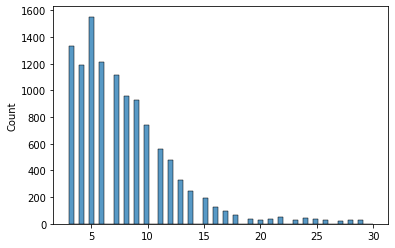

In [14]:
import seaborn as sns
sns.histplot(num_cols)

<Axes: ylabel='Count'>

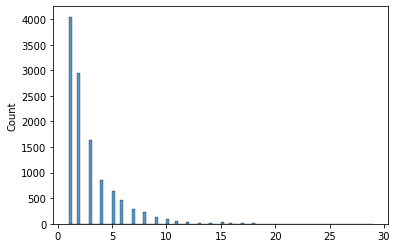

In [30]:
import seaborn as sns
sns.histplot(num_gt_cols)


In [32]:
max(num_gt_cols)

29

In [33]:
512/30

17.066666666666666